# Практическая работа №8 – Ассоциативные правила

In [150]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from apriori_python import apriori as apriori_a
from apyori import apriori as apriori_b
from efficient_apriori import apriori as apriori_c
from fpgrowth_py import fpgrowth

## Задание №1

Загрузить данные Market_Basket_Optimisation.csv.

In [151]:
data = pd.read_csv('./data/pract8/Market_Basket_Optimisation.csv')
data.head()

,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
0,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,low fat yogurt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Задание №2

Визуализировать данные (отразить на гистограммах относительную и фактическую частоту встречаемости для 20 наиболее популярных товаров).

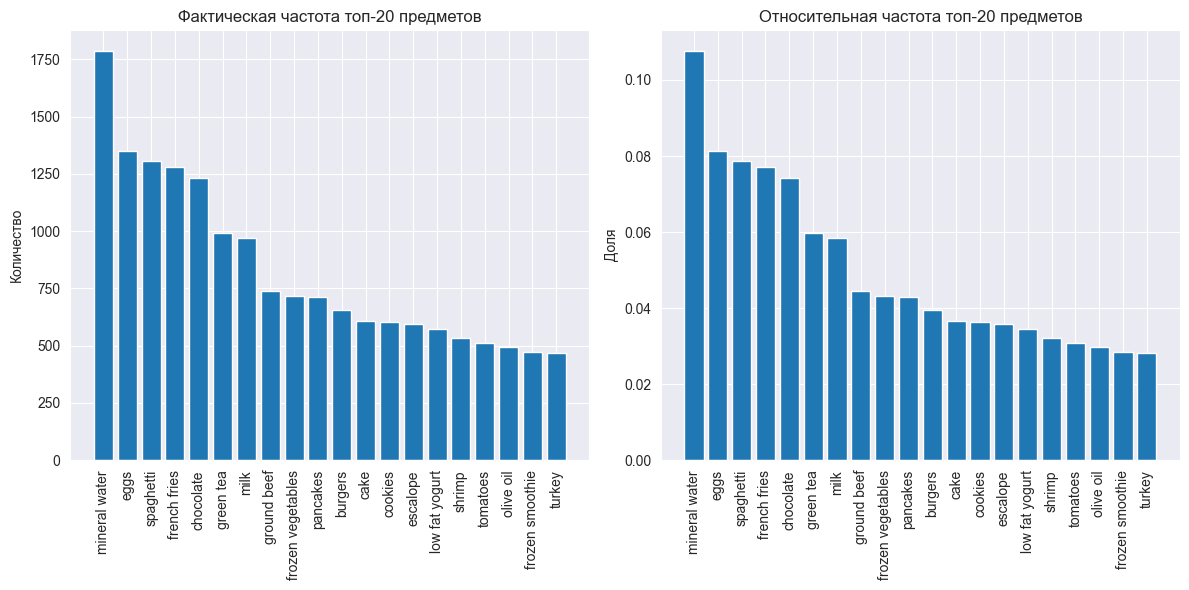

In [152]:
all_items = data.stack().tolist()
item_counts = pd.Series(all_items).value_counts().head(20)
item_counts_relative = item_counts / item_counts.sum()

plt.figure(figsize=(12, 6))

# Фактическая частота
plt.subplot(1, 2, 1)
plt.bar(item_counts.index, item_counts.values)
plt.xticks(rotation=90)
plt.title("Фактическая частота топ-20 предметов")
plt.ylabel("Количество")

# Относительная частота
plt.subplot(1, 2, 2)
plt.bar(item_counts_relative.index, item_counts_relative.values)
plt.xticks(rotation=90)
plt.title("Относительная частота топ-20 предметов")
plt.ylabel("Доля")

plt.tight_layout()
plt.show()

## Задание №3

Применить алгоритм Apriori, используя 3 разные библиотеки (apriori_python, apyori, efficient_apriori). Подобрать гиперпараметры для алгоритмов так, чтобы выводилось порядка 10 наилучших правил.

**Теория**:

Алгоритм Apriori — один из самых известных алгоритмов для поиска частых наборов элементов и генерации ассоциативных правил. Основная идея алгоритма заключается в том, что любой поднабор частого набора элементов тоже должен быть частым. Алгоритм использует эту идею, чтобы сузить пространство поиска, исключая нечастые наборы на ранних этапах.

**Фазы работы алгоритма**:

1.	Первый проход — поиск частых элементов (itemsets):
    - Алгоритм начинает с поиска всех отдельных элементов (itemsets с длиной 1), которые встречаются в транзакциях с частотой, превышающей заданное пороговое значение поддержки (min_support);
    - Поддержка (support) набора элементов — это доля транзакций, которые содержат этот набор.
2.	Генерация кандидатов на следующий уровень:
    - Из частых наборов длины 1 генерируются кандидаты длины 2 (пары элементов). Для генерации кандидатов используются только частые элементы из предыдущего шага;
    - Для этого применяются следующие правила:
        - Кандидаты (candidates) генерируются путём объединения частых наборов из предыдущего уровня;
        - Например, если {A} и {B} являются частыми наборами длины 1, то создаётся набор {A, B}.
3.	Фильтрация кандидатов по поддержке:
	- Алгоритм снова проходит по базе данных транзакций и вычисляет поддержку для каждого сгенерированного набора кандидатов;
	- Кандидаты, которые не удовлетворяют порогу минимальной поддержки, отбрасываются.
4.	Рекурсивное расширение:
	- Процесс продолжается, создаются кандидаты длины 3 на основе частых наборов длины 2, затем кандидаты длины 4 и так далее, пока не будет достигнут предел (или пока не останется наборов, удовлетворяющих порогу поддержки).
5.	Генерация ассоциативных правил:
	- Как только найдено множество всех частых наборов, на их основе можно генерировать ассоциативные правила;
	- Правила имеют вид {A} → {B}, где {A} и {B} — подмножества набора, и {A} является предпосылкой, а {B} — следствием;
	- Для каждого правила вычисляется:
        - Уверенность (confidence): вероятность того, что если покупатель приобрёл товары из {A}, то он также купил товары из {B};
        - Лифт (lift): насколько сильна ассоциация между {A} и {B}, по сравнению с их случайным совместным появлением.

**Параметры результата работы алгоритма**:

1.	Поддержка (Support) – показывает, как часто встречается комбинация товаров в транзакциях относительно общего числа транзакций.
    - Формула: $\text{Support}(A \to B) = \frac{\text{Количество транзакций, содержащих } A \text{ и } B}{\text{Общее количество транзакций}}$;
    - Пример: если поддержка правила {almonds} -> {burgers} равна 0.004, это означает, что комбинация “almonds и burgers” встречается в 0.4% всех транзакций.
2.	Доверие (Confidence) – измеряет, насколько часто товары из правой части правила покупаются вместе с товарами из левой части.
    - Формула: $\text{Confidence}(A \to B) = \frac{\text{Количество транзакций, содержащих } A \text{ и } B}{\text{Количество транзакций, содержащих } A}$;
    - Пример: если доверие правила {almonds} -> {burgers} равно 0.25, это означает, что в 25% случаев, когда покупают “almonds”, также покупают “burgers”.
3.	Лифт (Lift) – измеряет, насколько сильнее взаимосвязь между товарами, чем можно было бы ожидать при условии, что товары покупаются независимо. Лифт больше 1 указывает на положительную зависимость между товарами (т. е. товары покупаются вместе чаще, чем ожидалось), меньше 1 — на отрицательную зависимость.
    - Формула: $\text{Lift}(A \to B) = \frac{\text{Confidence}(A \to B)}{\text{Support}(B)}$;
    - Пример: если лифт равен 1.12, это означает, что вероятность совместной покупки “almonds” и “burgers” на 12% выше, чем если бы они покупались независимо.


In [153]:
# Список списков, где каждая строка — это транзакция с товарами
transactions = data.apply(lambda row: row.dropna().tolist(), axis=1).tolist()

def measure_execution_time(lambda_function):
    start_time = time.time()
    result = lambda_function()
    end_time = time.time()
    return end_time - start_time, result

times = []

In [154]:
def print_apriori_python_rules(rules):
    for i, rule in enumerate(rules, 1):
        antecedents = ', '.join(list(rule[0]))
        consequents = ', '.join(list(rule[1]))
        confidence = rule[2]
        
        print(f"Правило {i}:")
        print(f"  Если покупают: {antecedents}")
        print(f"  То также покупают: {consequents}")
        print(f"  Достоверность: {confidence:.4f}")
        if i < len(rules): print("-" * 50)

execution_time, (_ , res) = measure_execution_time(lambda: apriori_a(transactions, minSup=0.025, minConf=0.3))
times.append(execution_time)
top_rules = res[:10]

print_apriori_python_rules(top_rules)

Правило 1:
  Если покупают: chocolate
  То также покупают: mineral water
  Достоверность: 0.3214
--------------------------------------------------
Правило 2:
  Если покупают: burgers
  То также покупают: eggs
  Достоверность: 0.3303
--------------------------------------------------
Правило 3:
  Если покупают: cake
  То также покупают: mineral water
  Достоверность: 0.3388
--------------------------------------------------
Правило 4:
  Если покупают: spaghetti
  То также покупают: mineral water
  Достоверность: 0.3430
--------------------------------------------------
Правило 5:
  Если покупают: pancakes
  То также покупают: mineral water
  Достоверность: 0.3548
--------------------------------------------------
Правило 6:
  Если покупают: milk
  То также покупают: mineral water
  Достоверность: 0.3704
--------------------------------------------------
Правило 7:
  Если покупают: frozen vegetables
  То также покупают: mineral water
  Достоверность: 0.3748
-----------------------------

In [155]:
def print_apyori_rules(rules):
    for i, rule in enumerate(rules, 1):
        antecedents = ', '.join(list(rule.ordered_statistics[0].items_base))
        consequents = ', '.join(list(rule.ordered_statistics[0].items_add))
        support = rule.support
        confidence = rule.ordered_statistics[0].confidence
        lift = rule.ordered_statistics[0].lift
        
        print(f"Правило {i}:")
        print(f"  Если покупают: {antecedents}")
        print(f"  То также покупают: {consequents}")
        print(f"  Поддержка: {support:.4f}, Достоверность: {confidence:.4f}, Лифт: {lift:.4f}")
        if i < len(rules): print("-" * 50)

execution_time, res = measure_execution_time(lambda: list(apriori_b(transactions, min_support=0.025, min_confidence=0.3, min_lift=1.0001, min_length=2)))
times.append(execution_time)
top_rules = res[:10]

print_apyori_rules(top_rules)

Правило 1:
  Если покупают: burgers
  То также покупают: eggs
  Поддержка: 0.0288, Достоверность: 0.3303, Лифт: 1.8376
--------------------------------------------------
Правило 2:
  Если покупают: cake
  То также покупают: mineral water
  Поддержка: 0.0275, Достоверность: 0.3388, Лифт: 1.4220
--------------------------------------------------
Правило 3:
  Если покупают: chocolate
  То также покупают: mineral water
  Поддержка: 0.0527, Достоверность: 0.3214, Лифт: 1.3489
--------------------------------------------------
Правило 4:
  Если покупают: frozen vegetables
  То также покупают: mineral water
  Поддержка: 0.0357, Достоверность: 0.3748, Лифт: 1.5731
--------------------------------------------------
Правило 5:
  Если покупают: ground beef
  То также покупают: mineral water
  Поддержка: 0.0409, Достоверность: 0.4166, Лифт: 1.7483
--------------------------------------------------
Правило 6:
  Если покупают: ground beef
  То также покупают: spaghetti
  Поддержка: 0.0392, Достоверн

In [156]:
def print_efficient_apriori_rules(rules):
    for i, rule in enumerate(rules, 1):
        antecedents = ', '.join(list(rule.lhs))
        consequents = ', '.join(list(rule.rhs))
        support = rule.support
        confidence = rule.confidence
        lift = rule.lift
        
        print(f"Правило {i}:")
        print(f"  Если покупают: {antecedents}")
        print(f"  То также покупают: {consequents}")
        print(f"  Поддержка: {support:.4f}, Достоверность: {confidence:.4f}, Лифт: {lift:.4f}")
        if i < len(rules): print("-" * 50)

execution_time, (_ , res) = measure_execution_time(lambda: apriori_c(transactions, min_support=0.025, min_confidence=0.3))
times.append(execution_time)
top_rules = res[:10]

print_efficient_apriori_rules(top_rules)

Правило 1:
  Если покупают: burgers
  То также покупают: eggs
  Поддержка: 0.0288, Достоверность: 0.3303, Лифт: 1.8376
--------------------------------------------------
Правило 2:
  Если покупают: cake
  То также покупают: mineral water
  Поддержка: 0.0275, Достоверность: 0.3388, Лифт: 1.4220
--------------------------------------------------
Правило 3:
  Если покупают: chocolate
  То также покупают: mineral water
  Поддержка: 0.0527, Достоверность: 0.3214, Лифт: 1.3489
--------------------------------------------------
Правило 4:
  Если покупают: frozen vegetables
  То также покупают: mineral water
  Поддержка: 0.0357, Достоверность: 0.3748, Лифт: 1.5731
--------------------------------------------------
Правило 5:
  Если покупают: ground beef
  То также покупают: mineral water
  Поддержка: 0.0409, Достоверность: 0.4166, Лифт: 1.7483
--------------------------------------------------
Правило 6:
  Если покупают: ground beef
  То также покупают: spaghetti
  Поддержка: 0.0392, Достоверн

## Задание №4

Применить алгоритм FP-Growth из библиотеки fpgrowth_py. Подобрать гиперпараметры для алгоритма так, чтобы выводилось порядка 10 наилучших правил.

**Теория**:



In [157]:
def print_fpgrowth_rules(rules):
    for i, rule in enumerate(rules, 1):
        antecedents = ', '.join(list(rule[0]))
        consequents = ', '.join(list(rule[1]))
        confidence = rule[2]
        
        print(f"Правило {i}:")
        print(f"  Если покупают: {antecedents}")
        print(f"  То также покупают: {consequents}")
        print(f"  Достоверность: {confidence:.4f}")
        if i < len(rules): print("-" * 50)

execution_time, (_, res) = measure_execution_time(lambda: fpgrowth(transactions, minSupRatio=0.025, minConf=0.3))
times.append(execution_time)
top_rules = res[:10]

print_fpgrowth_rules(top_rules)

Правило 1:
  Если покупают: olive oil
  То также покупают: mineral water
  Достоверность: 0.4178
--------------------------------------------------
Правило 2:
  Если покупают: cake
  То также покупают: mineral water
  Достоверность: 0.3388
--------------------------------------------------
Правило 3:
  Если покупают: burgers
  То также покупают: eggs
  Достоверность: 0.3303
--------------------------------------------------
Правило 4:
  Если покупают: pancakes
  То также покупают: mineral water
  Достоверность: 0.3548
--------------------------------------------------
Правило 5:
  Если покупают: frozen vegetables
  То также покупают: mineral water
  Достоверность: 0.3748
--------------------------------------------------
Правило 6:
  Если покупают: ground beef
  То также покупают: spaghetti
  Достоверность: 0.3989
--------------------------------------------------
Правило 7:
  Если покупают: ground beef
  То также покупают: mineral water
  Достоверность: 0.4166
------------------------

## Задание №5

Сравнить время выполнения всех алгоритмов и построить гистограмму.

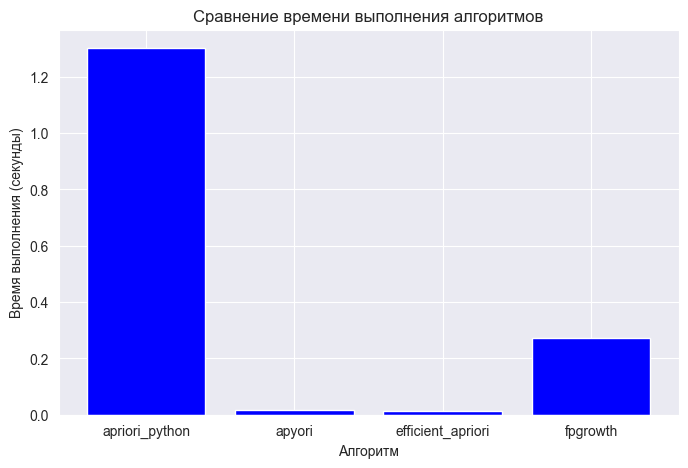

In [158]:
algorithms = ['apriori_python', 'apyori', 'efficient_apriori', 'fpgrowth']

# Построение гистограммы времени выполнения
plt.figure(figsize=(8, 5))
plt.bar(algorithms, times, color='blue')
plt.xlabel('Алгоритм')
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение времени выполнения алгоритмов')
plt.show()

- apriori_python: 1.30 секунды — самый медленный алгоритм;
- apyori и efficient_apriori: очень быстрые, выполняются менее чем за 0.02 секунды;
- fpgrowth: также достаточно быстрый, около 0.28 секунд.

## Задание №6

Загрузить данные data.csv.

In [159]:
data = pd.read_csv('./data/pract8/data.csv')
data.head()

,Bread,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,Scandinavian,Scandinavian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Hot chocolate,Jam,Cookies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Muffin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Coffee,Pastry,Bread,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Medialuna,Pastry,Muffin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Задание №7

Визуализировать данные (отразить на гистограммах относительную и фактическую частоту встречаемости для 20 наиболее популярных товаров).

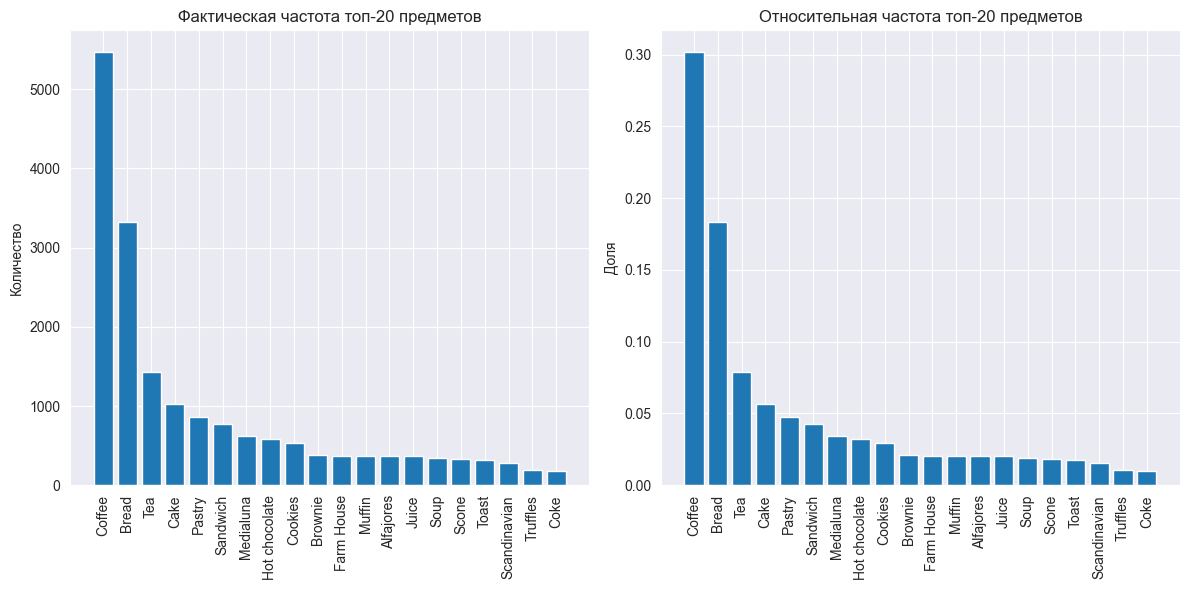

In [160]:
all_items = data.stack().tolist()
item_counts = pd.Series(all_items).value_counts().head(20)
item_counts_relative = item_counts / item_counts.sum()

plt.figure(figsize=(12, 6))

# Фактическая частота
plt.subplot(1, 2, 1)
plt.bar(item_counts.index, item_counts.values)
plt.xticks(rotation=90)
plt.title("Фактическая частота топ-20 предметов")
plt.ylabel("Количество")

# Относительная частота
plt.subplot(1, 2, 2)
plt.bar(item_counts_relative.index, item_counts_relative.values)
plt.xticks(rotation=90)
plt.title("Относительная частота топ-20 предметов")
plt.ylabel("Доля")

plt.tight_layout()
plt.show()

## Задание №8

Применить алгоритм Apriori, используя 3 разные библиотеки (apriori_python, apyori, efficient_apriori). Подобрать гиперпараметры для алгоритмов так, чтобы выводилось порядка 10 наилучших правил.

In [161]:
transactions = data.apply(lambda row: row.dropna().tolist(), axis=1).tolist()
times = []

In [162]:
execution_time, (_, res) = measure_execution_time(lambda: apriori_a(transactions, minSup=0.0225, minConf=0.275))
times.append(execution_time)

print_apriori_python_rules(res)

Правило 1:
  Если покупают: Bread
  То также покупают: Coffee
  Достоверность: 0.2752
--------------------------------------------------
Правило 2:
  Если покупают: Pastry
  То также покупают: Bread
  Достоверность: 0.3387
--------------------------------------------------
Правило 3:
  Если покупают: Tea
  То также покупают: Coffee
  Достоверность: 0.3496
--------------------------------------------------
Правило 4:
  Если покупают: Hot chocolate
  То также покупают: Coffee
  Достоверность: 0.5072
--------------------------------------------------
Правило 5:
  Если покупают: Cookies
  То также покупают: Coffee
  Достоверность: 0.5184
--------------------------------------------------
Правило 6:
  Если покупают: Cake
  То также покупают: Coffee
  Достоверность: 0.5270
--------------------------------------------------
Правило 7:
  Если покупают: Sandwich
  То также покупают: Coffee
  Достоверность: 0.5324
--------------------------------------------------
Правило 8:
  Если покупают: Pas

In [163]:
execution_time, res = measure_execution_time(
    lambda: list(apriori_b(transactions, min_support=0.025, min_confidence=0.3)))
times.append(execution_time)

print_apyori_rules(res)

Правило 1:
  Если покупают: 
  То также покупают: Bread
  Поддержка: 0.3249, Достоверность: 0.3249, Лифт: 1.0000
--------------------------------------------------
Правило 2:
  Если покупают: 
  То также покупают: Coffee
  Поддержка: 0.4751, Достоверность: 0.4751, Лифт: 1.0000
--------------------------------------------------
Правило 3:
  Если покупают: Pastry
  То также покупают: Bread
  Поддержка: 0.0290, Достоверность: 0.3387, Лифт: 1.0424
--------------------------------------------------
Правило 4:
  Если покупают: Cake
  То также покупают: Coffee
  Поддержка: 0.0544, Достоверность: 0.5270, Лифт: 1.1091
--------------------------------------------------
Правило 5:
  Если покупают: Cookies
  То также покупают: Coffee
  Поддержка: 0.0280, Достоверность: 0.5184, Лифт: 1.0912
--------------------------------------------------
Правило 6:
  Если покупают: Hot chocolate
  То также покупают: Coffee
  Поддержка: 0.0294, Достоверность: 0.5072, Лифт: 1.0676
---------------------------------

In [164]:
execution_time, (_ , res) = measure_execution_time(lambda: apriori_c(transactions, min_support=0.0225, min_confidence=0.275))
times.append(execution_time)

print_efficient_apriori_rules(res)

Правило 1:
  Если покупают: Bread
  То также покупают: Coffee
  Поддержка: 0.0894, Достоверность: 0.2752, Лифт: 0.5792
--------------------------------------------------
Правило 2:
  Если покупают: Pastry
  То также покупают: Bread
  Поддержка: 0.0290, Достоверность: 0.3387, Лифт: 1.0424
--------------------------------------------------
Правило 3:
  Если покупают: Cake
  То также покупают: Coffee
  Поддержка: 0.0544, Достоверность: 0.5270, Лифт: 1.1091
--------------------------------------------------
Правило 4:
  Если покупают: Cookies
  То также покупают: Coffee
  Поддержка: 0.0280, Достоверность: 0.5184, Лифт: 1.0912
--------------------------------------------------
Правило 5:
  Если покупают: Hot chocolate
  То также покупают: Coffee
  Поддержка: 0.0294, Достоверность: 0.5072, Лифт: 1.0676
--------------------------------------------------
Правило 6:
  Если покупают: Medialuna
  То также покупают: Coffee
  Поддержка: 0.0349, Достоверность: 0.5692, Лифт: 1.1980
------------------

## Задание №9

Применить алгоритм FP-Growth из библиотеки fpgrowth_py. Подобрать гиперпараметры для алгоритма так, чтобы выводилось порядка 10 наилучших правил.

In [165]:
execution_time, (_, res) = measure_execution_time(lambda: fpgrowth(transactions, minSupRatio=0.0275, minConf=0.3))
times.append(execution_time)

print_fpgrowth_rules(res)

Правило 1:
  Если покупают: Toast
  То также покупают: Coffee
  Достоверность: 0.7044
--------------------------------------------------
Правило 2:
  Если покупают: Alfajores
  То также покупают: Coffee
  Достоверность: 0.5407
--------------------------------------------------
Правило 3:
  Если покупают: Cookies
  То также покупают: Coffee
  Достоверность: 0.5184
--------------------------------------------------
Правило 4:
  Если покупают: Hot chocolate
  То также покупают: Coffee
  Достоверность: 0.5072
--------------------------------------------------
Правило 5:
  Если покупают: Medialuna
  То также покупают: Coffee
  Достоверность: 0.5692
--------------------------------------------------
Правило 6:
  Если покупают: Sandwich
  То также покупают: Coffee
  Достоверность: 0.5324
--------------------------------------------------
Правило 7:
  Если покупают: Pastry
  То также покупают: Bread
  Достоверность: 0.3387
--------------------------------------------------
Правило 8:
  Если по

## Задание №10

Сравнить время выполнения всех алгоритмов и построить гистограмму.

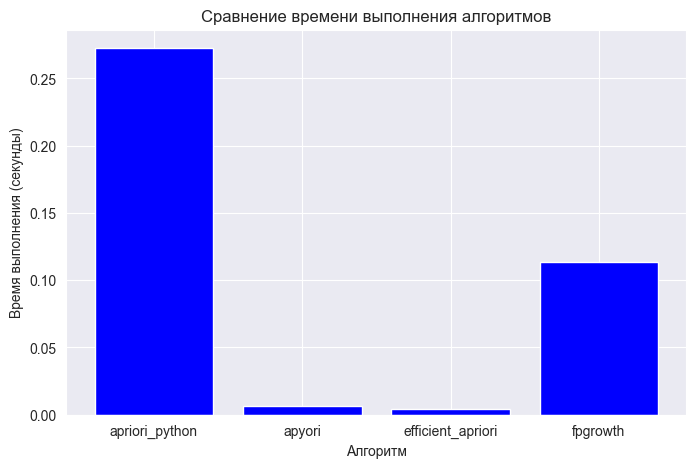

In [166]:
algorithms = ['apriori_python', 'apyori', 'efficient_apriori', 'fpgrowth']

# Построение гистограммы времени выполнения
plt.figure(figsize=(8, 5))
plt.bar(algorithms, times, color='blue')
plt.xlabel('Алгоритм')
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение времени выполнения алгоритмов')
plt.show()

1.	apriori_python:
    - Время выполнения: 0.273 секунд.
    - Это самый медленный из алгоритмов, хотя его время выполнения заметно сократилось по сравнению с предыдущими данными (1.30 секунды).
2.	apyori:
    - Время выполнения: 0.0067 секунд;
    - Выполняется почти мгновенно, что делает его одним из самых быстрых алгоритмов в этой выборке.
3.	efficient_apriori:
    - Время выполнения: 0.0045 секунд;
    - Это самый быстрый алгоритм, выполняется практически мгновенно.
4.	fpgrowth:
    - Время выполнения: 0.113 секунд;
    - Этот алгоритм выполняется быстрее, чем apriori_python, но медленнее, чем другие алгоритмы Apriori, хотя всё еще достаточно быстро.